# Time series project

## Elnaz semsarzadeh

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [24]:
# Load data
data = pd.read_csv('ts2024.csv')
data.head()




,DateTime,Date,Hour,X
0,2015-01-01,2015-01-01,0,0.0146
1,2015-01-01 01:00:00,2015-01-01,1,0.0148
2,2015-01-01 02:00:00,2015-01-01,2,0.0101
3,2015-01-01 03:00:00,2015-01-01,3,0.0060
4,2015-01-01 04:00:00,2015-01-01,4,0.0055


C:\Users\Elnaz\AppData\Local\Temp\ipykernel_9000\1767356047.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce', infer_datetime_format=True)


16813


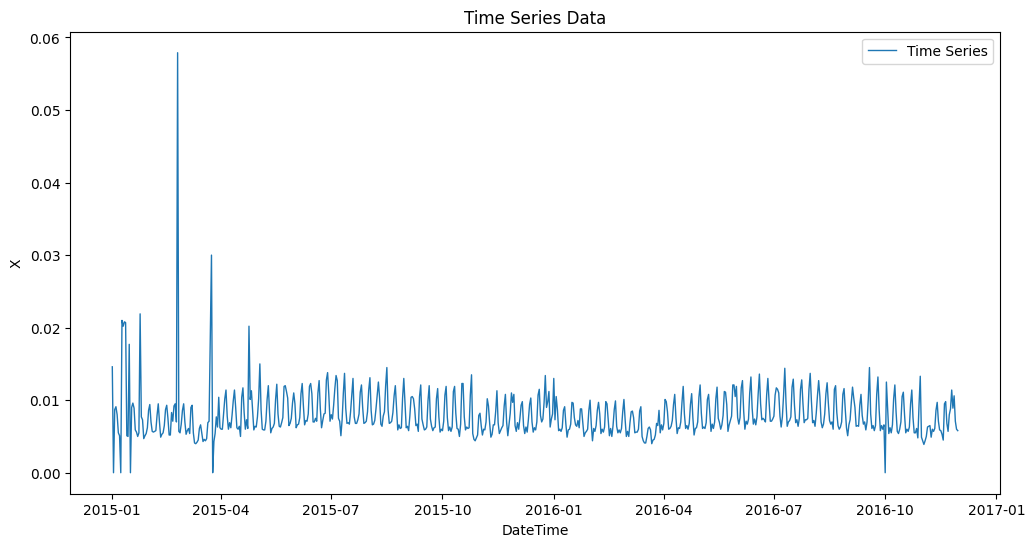

In [25]:
# Inspect the data
# data.tail()
# data.info()
# data.describe()

# Convert DateTime to datetime format
data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce', infer_datetime_format=True)

# Check for invalid DateTime entries
print(data['DateTime'].isna().sum())  # To verify if any rows failed to convert

# Drop rows with invalid DateTime if necessary
data = data.dropna(subset=['DateTime'])

# Set DateTime as the index
data.set_index('DateTime', inplace=True)

# Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(data['X'], label='Time Series', linewidth=1)
plt.title('Time Series Data')
plt.xlabel('DateTime')
plt.ylabel('X')
plt.legend()
plt.show()

### From the plot, you can observe:

- Trends: Is there a general upward or downward movement over time?
        Example: A rising trend could indicate growth, while a downward trend might indicate a decline.
- Seasonality: Do patterns repeat periodically (e.g., daily or weekly)?
        Example: A periodic rise and fall could indicate daily or seasonal cycles.
- Volatility: Are the changes in X small and steady, or large and abrupt?
        Example: Spikes may signify events or anomalies in the data.
- Missing or Flat Data: If the line is flat or drops off suddenly, it might indicate missing data

In [26]:
data = pd.read_csv('ts2024.csv')

C:\Users\Elnaz\AppData\Local\Temp\ipykernel_9000\1639633158.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce', infer_datetime_format=True)


Invalid DateTime entries found: 16813 rows


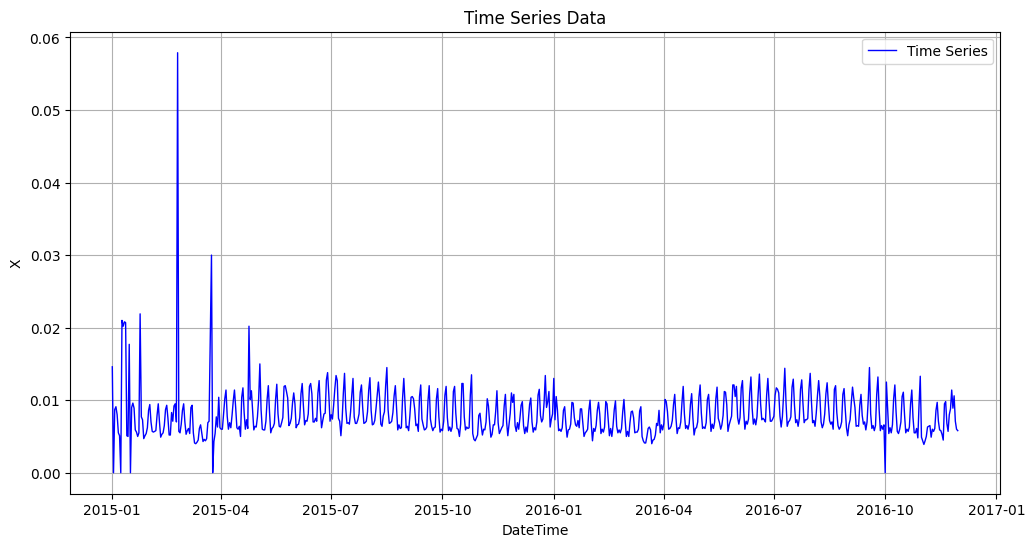

In [27]:
# Strip white

data.columns = data.columns.str.strip()

# Check if 'DateTime' column exists
if 'DateTime' not in data.columns:
    raise KeyError("'DateTime' column not found in the dataset. Verify column names.")

# Convert DateTime to datetime format
data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce', infer_datetime_format=True)

# Check for invalid DateTime entries
if data['DateTime'].isna().sum() > 0:
    print(f"Invalid DateTime entries found: {data['DateTime'].isna().sum()} rows")
    # Drop rows with invalid DateTime if necessary
    data = data.dropna(subset=['DateTime'])

# Set DateTime as the index
data.set_index('DateTime', inplace=True)

# Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(data['X'], label='Time Series', linewidth=1, color='blue')
plt.title('Time Series Data')
plt.xlabel('DateTime')
plt.ylabel('X')
plt.legend()
plt.grid()
plt.show()



In [28]:
data.isnull().sum()

Date     0
Hour     0
X       31
dtype: int64

In [29]:
data

,Date,Hour,X
DateTime,,,
2015-01-01,2015-01-01,0,0.0146
2015-01-02,2015-01-02,0,0.0000
2015-01-03,2015-01-03,0,0.0087
2015-01-04,2015-01-04,0,0.0091
2015-01-05,2015-01-05,0,0.0080
...,...,...,...
2016-12-27,2016-12-27,0,NaN
2016-12-28,2016-12-28,0,NaN
2016-12-29,2016-12-29,0,NaN


In [30]:
train_data = data['X'].dropna()

In [31]:
train_data.isnull().sum()

0

In [32]:
train_data

DateTime
2015-01-01    0.0146
2015-01-02    0.0000
2015-01-03    0.0087
2015-01-04    0.0091
2015-01-05    0.0080
               ...  
2016-11-26    0.0089
2016-11-27    0.0106
2016-11-28    0.0071
2016-11-29    0.0060
2016-11-30    0.0058
Name: X, Length: 700, dtype: float64

In [33]:
predict_dates = data['X'][data['X'].isnull()].index

In [34]:
predict_dates

DatetimeIndex(['2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15', '2016-12-16',
               '2016-12-17', '2016-12-18', '2016-12-19', '2016-12-20',
               '2016-12-21', '2016-12-22', '2016-12-23', '2016-12-24',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='DateTime', freq=None)

In [35]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -4.566098808273295
p-value: 0.0001490869571427943


## ARIMA Model

In [38]:
from pmdarima import auto_arima

# Find optimal ARIMA parameters
arima_model = auto_arima(train_data, seasonal=True, m=24, trace=True, suppress_warnings=True)
print(arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-5984.157, Time=10.17 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-5665.598, Time=0.39 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-5752.654, Time=1.89 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-5798.208, Time=4.19 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-5667.591, Time=0.10 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=-5975.726, Time=11.10 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=-5976.320, Time=13.05 sec
 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=-5982.967, Time=73.52 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=-5983.897, Time=41.49 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=-5939.189, Time=1.70 sec
 ARIMA(2,1,2)(0,0,2)[24] intercept   : AIC=-5987.236, Time=43.07 sec
 ARIMA(1,1,2)(0,0,2)[24] intercept   : AIC=-5978.680, Time=34.47 sec
 ARIMA(2,1,1)(0,0,2)[24] intercept   : AIC=-5880.055, Time=15.55 sec
 ARIMA(3,1,2)(0,0,2)[24] intercept   : AIC=-5705.078, Time=50.15 